In [1]:
import numpy as np
import rsatoolbox
from rsatoolbox.util.matrix import pairwise_contrast
from scipy.spatial.distance import squareform
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
from scipy import linalg
from scipy.optimize import minimize
from scipy import io


In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])

In [3]:
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

In [4]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
# conv2_rdms = model_rdms.subset('brain_computational_model','conv2')

#fig, ax, ret_val = rsatoolbox.vis.show_rdm(conv1_rdms, rdm_descriptor='measurement_model', figsize=(10,10))

# fun = lambda a: np.sqrt((np.log(linalg.eigvalsh(G1,np.exp(a)*G2))**2).sum())
# res = minimize(fun,0, method='Nelder-Mead')
# print(np.exp(res.x))
# a_true = 1/np.exp(-np.log(linalg.eigvalsh(G1,G2)).sum()/np.shape(G1)[0])
# print(a_true)

# rsatoolbox.rdm.compare_neg_riemannian_distance(conv1_rdms,conv2_rdms)

In [5]:
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')

In [6]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = rsatoolbox.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

# fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_data, figsize=(10,10))

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


In [7]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


In [8]:
results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='neg_riem_dist')


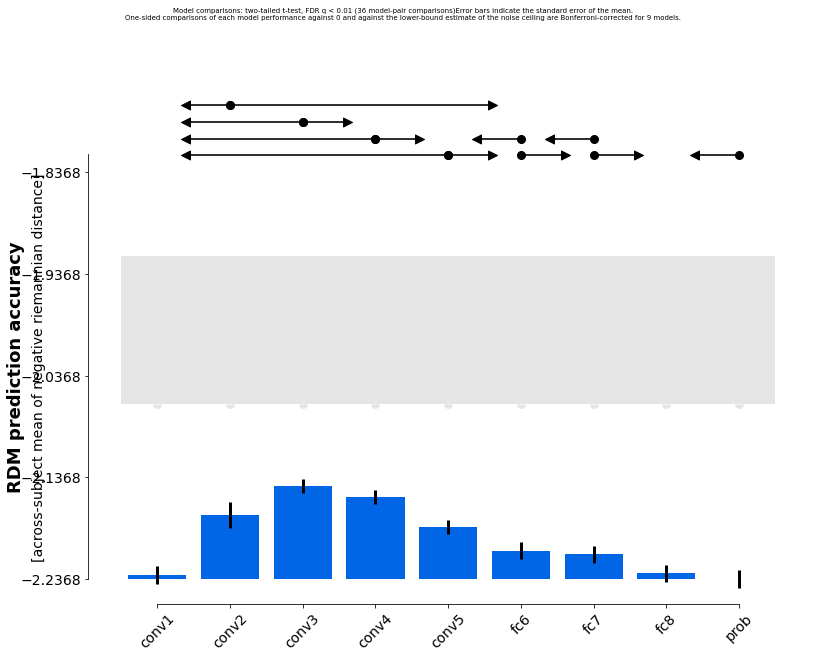

In [11]:
rsatoolbox.vis.plot_model_comparison(results_1)

In [13]:
results_2a = rsatoolbox.inference.eval_bootstrap_rdm(models, rdms_data, method='neg_riem_dist',N=10)


100%|██████████| 10/10 [03:59<00:00, 23.98s/it]


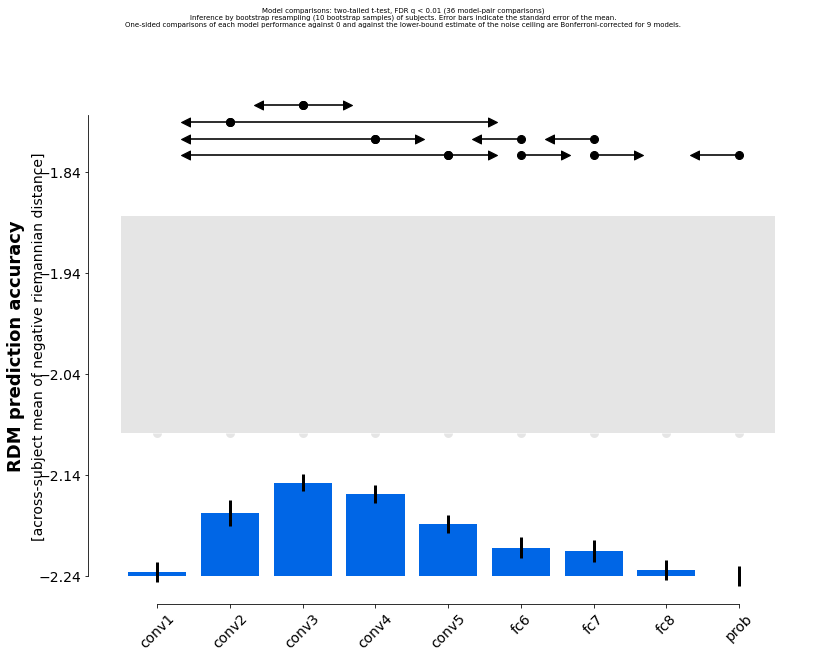

In [14]:
rsatoolbox.vis.plot_model_comparison(results_2a)

In [29]:
perf

array([2.23283201, 2.17390947, 2.1451409 , 2.15664203, 2.18561683,
       2.20896383, 2.21241333, 2.2312687 , 2.23681389])